# Introduction to generative adversarial networks
![title](./pics/gans.png)

GANs are: a forger network network and an expert network, each being trained to best the other. As such, a GAN is made of two parts:

- A generator network, which takes as input a random vector (a random point in the latent space) and decodes it into a synthetic image.
- A discriminator network (also called adversary), which takes as input an image (real or synthetic), and must predict whether the image came from the training set or was created by the generator network.

In [12]:
# imports

# keras imports
from keras.preprocessing import image
from keras import layers
import keras

# general imports
import numpy as np
import cv2
import os

# visualiaztion imports
%matplotlib inline
import matplotlib.pyplot as plt

## The generator

generator model, which turns a vector (from the latent space—during training it will sampled at random) into a candidate image

In [2]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

## The discriminator
we develop a discriminator model, that takes as input a candidate image (real or synthetic) and classifies it into one of two classes, either "generated image" or "real image that comes from the training set"

In [6]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

## The adversarial network
we setup the GAN, which chains the generator and the discriminator. So training gan will updates the weights of generator in a way that makes discriminator more likely to predict "real" when looking at fake images

In [7]:
# Very importantly, we set the discriminator to be frozen during 
# training (non-trainable): its weights will not be updated when training gan. 
# If the discriminator weights could be updated during this process, then we would 
# be training the discriminator to always predict "real", which is not what we want!

# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))

gan = keras.models.Model(gan_input, gan_output)
gan.summary()
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_5 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


## How to train your DCGAN

for each epoch:
    - Draw random points in the latent space (random noise).
    - Generate images with `generator` using this random noise.
    - Mix the generated images with real ones.
    - Train `discriminator` using these mixed images, with corresponding targets, either "real" (f
    - Draw new random points in the latent space.
    - Train `gan` using these random vectors, with targets that all say "these are real images"

In [10]:
# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_results/'

# Start training loop
start = 0
for step in range(iterations):
    
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
    
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)
    
    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))
    
    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('./gan_results/gan.h5')
        
        # Print metrics
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        
        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

discriminator loss: 5.7844934
adversarial loss: 14.990155
discriminator loss: 0.68751794
adversarial loss: 0.9046753
discriminator loss: 0.68895566
adversarial loss: 0.8020092
discriminator loss: 0.70740527
adversarial loss: 0.7645803
discriminator loss: 0.7041891
adversarial loss: 0.73935604
discriminator loss: 0.7159769
adversarial loss: 0.7173287
discriminator loss: 0.6933198
adversarial loss: 0.7591053
discriminator loss: 0.6894836
adversarial loss: 0.7472523
discriminator loss: 0.70067275
adversarial loss: 0.73695374
discriminator loss: 0.68531334
adversarial loss: 0.75604993
discriminator loss: 0.6956596
adversarial loss: 0.7574953
discriminator loss: 0.6925049
adversarial loss: 0.8289049
discriminator loss: 0.6971407
adversarial loss: 0.75083125
discriminator loss: 0.6993327
adversarial loss: 0.7599758
discriminator loss: 0.69923913
adversarial loss: 0.692557
discriminator loss: 0.69546473
adversarial loss: 0.7646657
discriminator loss: 0.692471
adversarial loss: 0.7896539
discr

### results

Text(0.5, 1.0, 'generated from image after 9800 iterations')

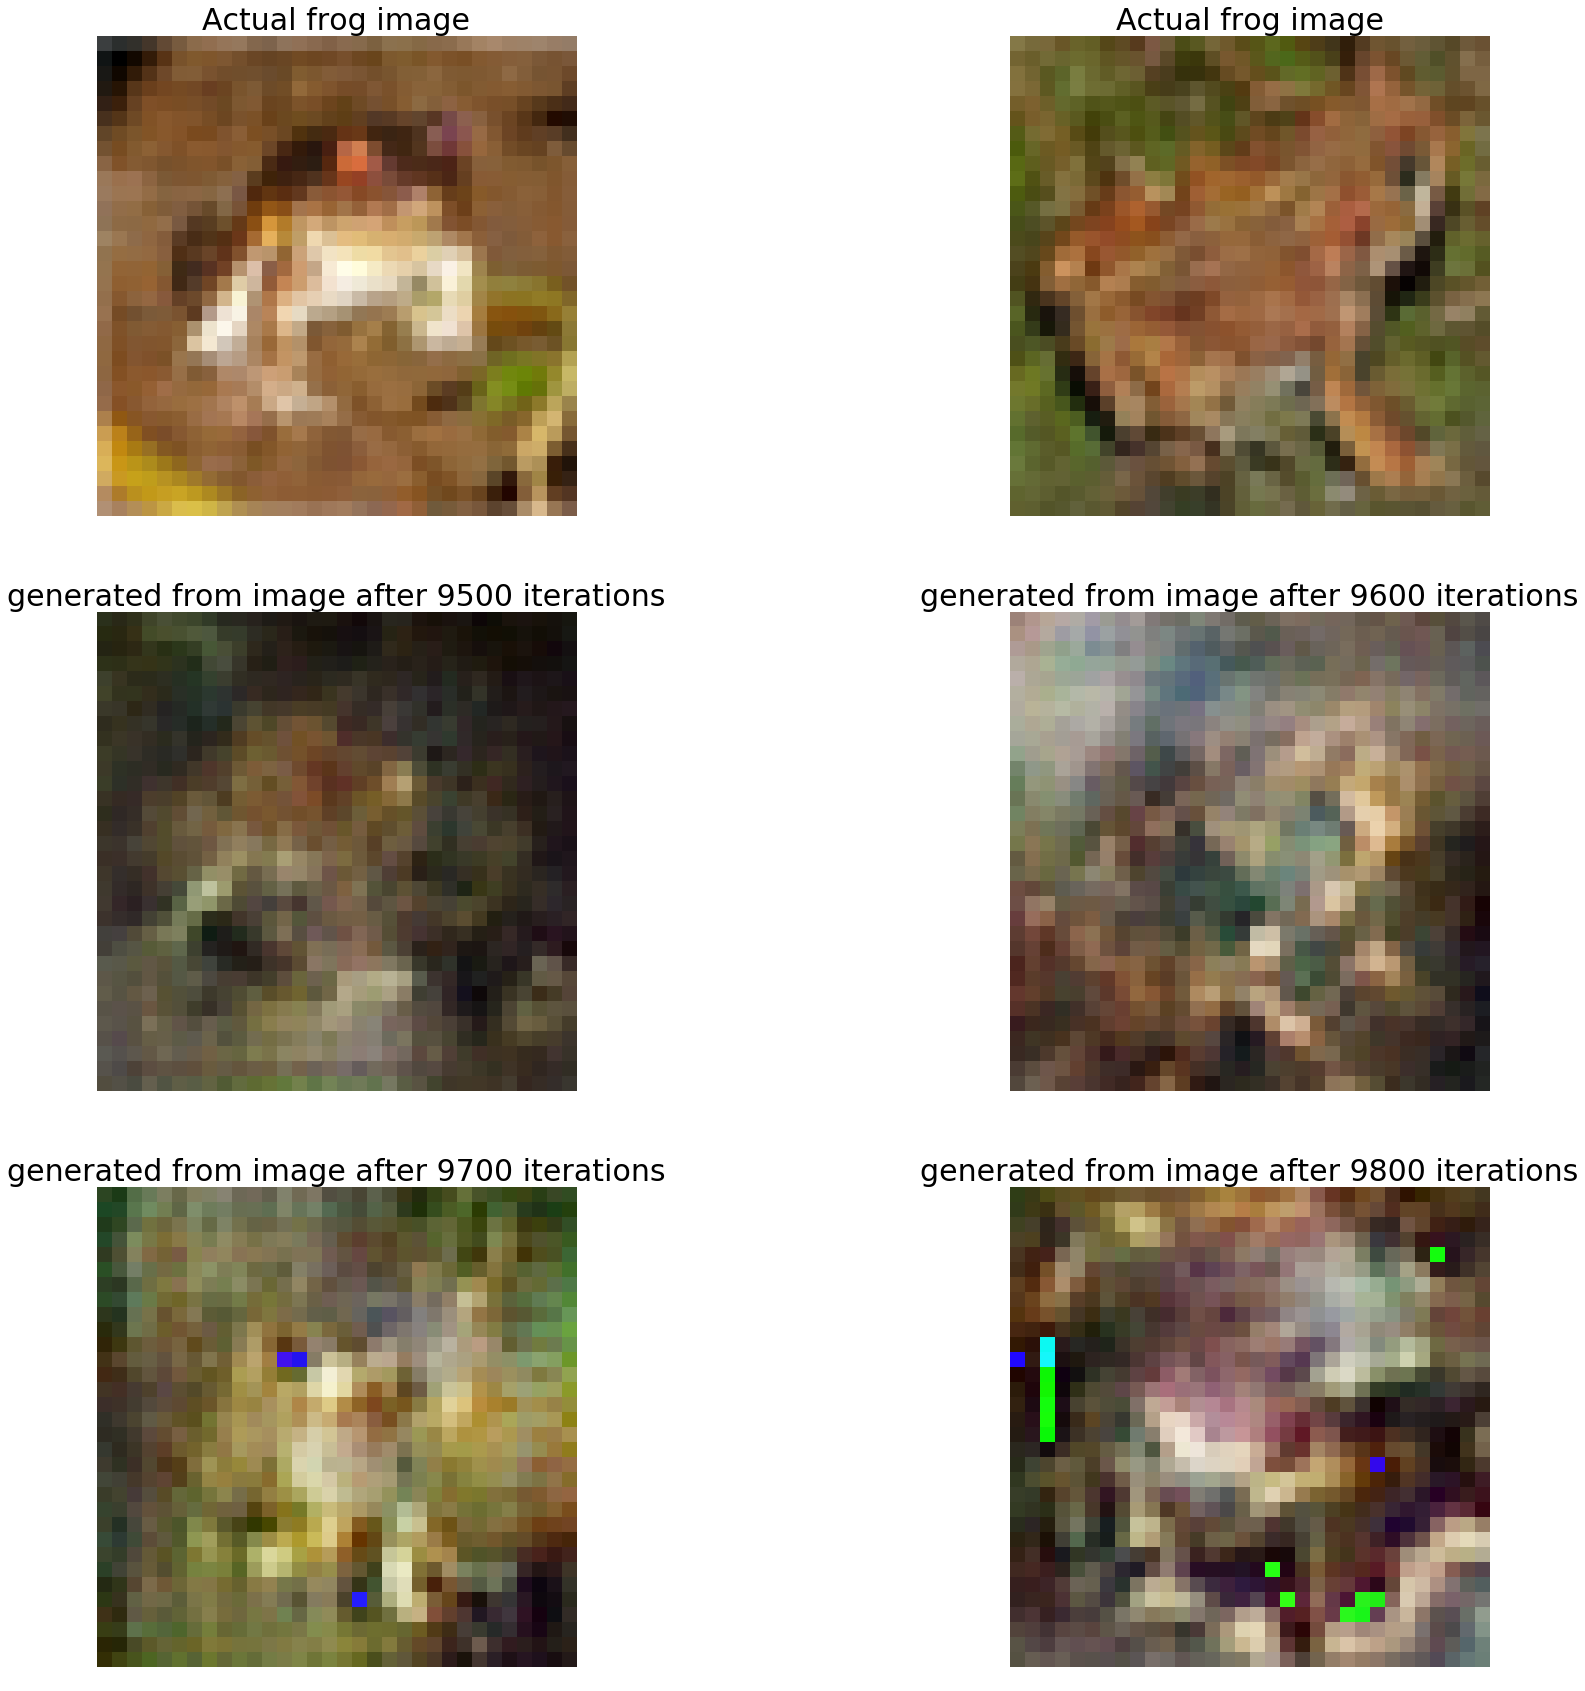

In [13]:
def read_image(path):
    return  cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(read_image("./pics/real_frog9500.png"))
plt.axis('off')
plt.title("Actual frog image",fontsize=30)
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(read_image("./pics/real_frog9600.png"))
plt.axis('off')
plt.title("Actual frog image",fontsize=30)
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(read_image("./pics/generated_frog9500.png"))
plt.axis('off')
plt.title("generated from image after 9500 iterations",fontsize=30)
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(read_image("./pics/generated_frog9600.png"))
plt.axis('off')
plt.title("generated from image after 9600 iterations",fontsize=30)

### list of GAN-related training tricks:
    
- We use tanh as the last activation in the generator, instead of sigmoid, which would bemore commonly found in other types of models.

- We sample points from the latent space using a normal distribution (Gaussian distribution), not a uniform distribution.

- Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) we add some random noise to the labels for the discriminator.

- Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a LeakyReLU layer instead of a ReLU activation. It is similar to ReLU but it relaxes sparsity constraints by allowing small negative activation values.

- In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that isdivisible by the stride size, whenever we use a strided Conv2DTranpose or Conv2D in both the generator and discriminator.
